🎯 NIPT 检测累计达标率 + 风险分析系统 v3.0

📂 正在读取数据 ...
➡ 原始数据共 1082 条记录
➡ 删除无效 Y 浓度后剩余 1082 条记录
➡ 筛选孕周 10-25 周后剩余 940 条记录
➡ 筛选 GC 含量后剩余 533 条记录
✅ 数据清洗完成，可用样本数：533

📊 正在进行 BMI Jenks 分组 ...
➡ BMI组1 | 样本数=200 | 区间=26.6-31.0
➡ BMI组2 | 样本数=180 | 区间=31.1-33.6
➡ BMI组3 | 样本数=132 | 区间=33.7-37.5
➡ BMI组4 | 样本数=21 | 区间=37.6-46.9
✅ BMI 分组完成

📈 正在计算累计达标率曲线 ...
➡ BMI组1 | 样本=200 | 推荐孕周=15.57 | 达标率=50.1% | 风险=3.57
➡ BMI组2 | 样本=180 | 推荐孕周=15.57 | 达标率=52.6% | 风险=3.57
➡ BMI组3 | 样本=132 | 推荐孕周=16.57 | 达标率=50.7% | 风险=4.57
➡ BMI组4 | 样本=21 | 推荐孕周=18.86 | 达标率=50.8% | 风险=6.86


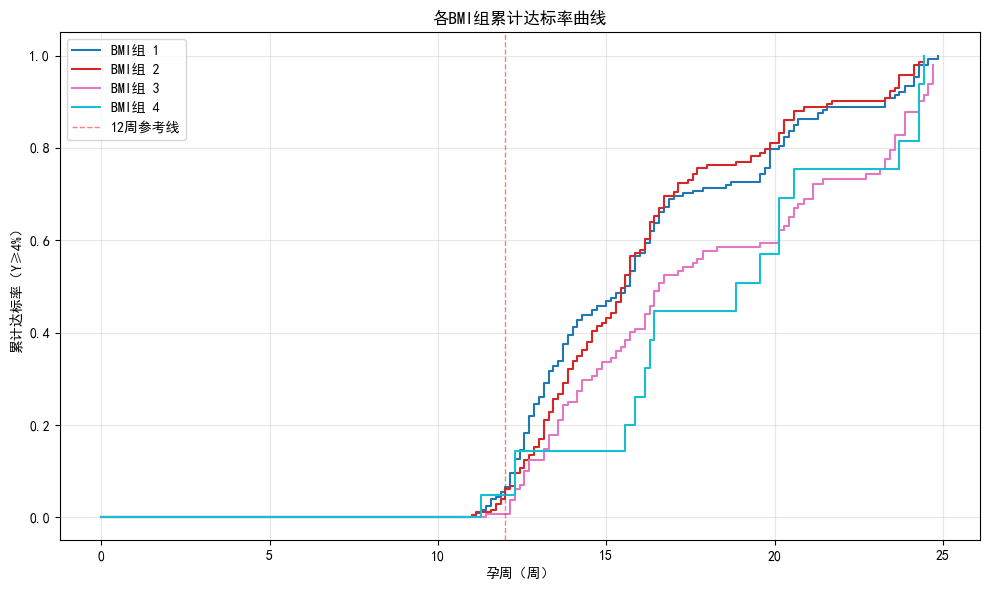

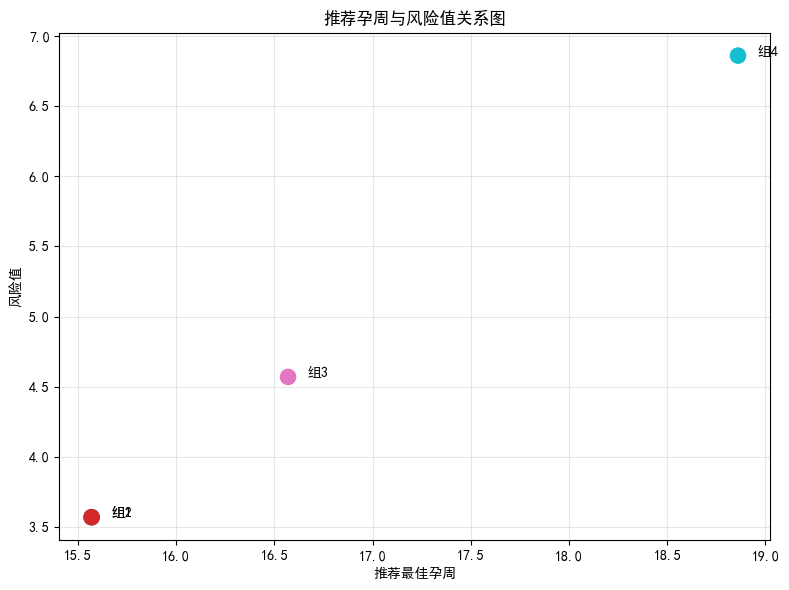


🔥 正在生成热力图 ...


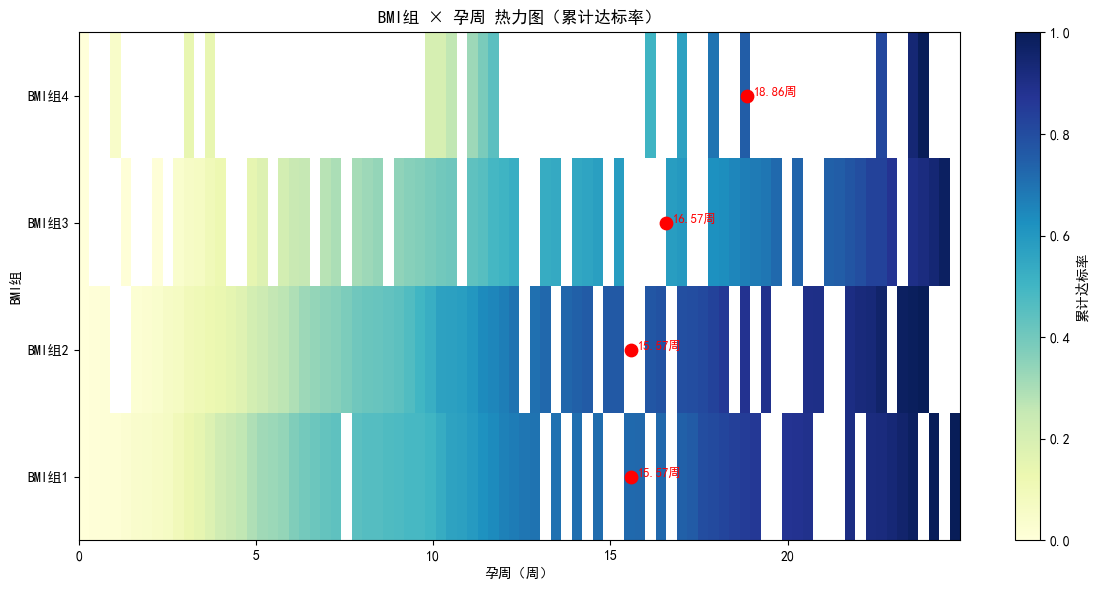


📑 【各组最佳孕周推荐】
BMI组     BMI区间  推荐最佳孕周   达标率  风险值
  组1 26.6-31.0   15.57 50.1% 3.57
  组2 31.1-33.6   15.57 52.6% 3.57
  组3 33.7-37.5   16.57 50.7% 4.57
  组4 37.6-46.9   18.86 50.8% 6.86

✅ 全流程完成！累计达标率曲线、推荐孕周表和风险散点图已生成。


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import mapclassify
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# ------------------------------------------------------------------------------  
# 1. 数据预处理  
# ------------------------------------------------------------------------------  
def preprocess_nipt_data(file_path, sheet_name="男胎检测数据"):
    print("\n📂 正在读取数据 ...")
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    df.columns = df.columns.str.strip()
    print(f"➡ 原始数据共 {len(df)} 条记录")

    y_col = "Y染色体浓度"
    week_col = "检测孕周"
    gc_col = "GC含量"
    bmi_col = "孕妇BMI"

    # 仅保留有效 Y 浓度样本
    df = df[df[y_col].notna()].copy()
    print(f"➡ 删除无效 Y 浓度后剩余 {len(df)} 条记录")

    # 将孕周转成小数
    def convert_week(week_str):
        if pd.isna(week_str) or "+" not in str(week_str):
            return np.nan
        try:
            week_part, day_part = str(week_str).split("+")
            return round(int(week_part.replace("w", "")) + int(day_part) / 7, 2)
        except:
            return np.nan

    df["孕周_小数"] = df[week_col].apply(convert_week)
    df = df[(df["孕周_小数"] >= 10) & (df["孕周_小数"] <= 25)].copy()
    print(f"➡ 筛选孕周 10-25 周后剩余 {len(df)} 条记录")

    # 筛选正常 GC 含量
    df = df[(df[gc_col] >= 0.4) & (df[gc_col] <= 0.6)].copy()
    if len(df) == 0:
        df = df[(df[gc_col] >= 0.38) & (df[gc_col] <= 0.62)].copy()
        print(f"⚠ 严格 GC 筛选无数据，放宽至 0.38-0.62 区间")

    print(f"➡ 筛选 GC 含量后剩余 {len(df)} 条记录")

    df_final = df[[bmi_col, "孕周_小数", y_col]].dropna().reset_index(drop=True)
    print(f"✅ 数据清洗完成，可用样本数：{len(df_final)}")
    return df_final, bmi_col, y_col, "孕周_小数"


# ------------------------------------------------------------------------------  
# 2. Jenks 分组  
# ------------------------------------------------------------------------------  
def jenks_bmi_grouping(df, bmi_col, n_classes=4):
    print("\n📊 正在进行 BMI Jenks 分组 ...")
    classifier = mapclassify.NaturalBreaks(df[bmi_col], k=n_classes)
    df['BMI组'] = classifier.yb

    # 输出每组的情况
    for g in sorted(df['BMI组'].unique()):
        group = df[df['BMI组'] == g]
        print(f"➡ BMI组{g+1} | 样本数={len(group)} | 区间={group[bmi_col].min():.1f}-{group[bmi_col].max():.1f}")

    print("✅ BMI 分组完成")
    return df


# ------------------------------------------------------------------------------  
# 3. 累计达标率 + 风险分析  
# ------------------------------------------------------------------------------  
def cumulative_survival_analysis(df, bmi_col, y_col, week_col, target_rate=0.5):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, df['BMI组'].nunique()))
    results = []
    summary_table = {}

    print("\n📈 正在计算累计达标率曲线 ...")

    for g, color in zip(sorted(df['BMI组'].unique()), colors):
        group = df[df['BMI组'] == g].copy()
        group['event'] = (group[y_col] >= 0.04).astype(int)
        group['time'] = group[week_col]

        kmf.fit(group['time'], event_observed=group['event'], label=f'BMI组 {g+1}')
        surv = kmf.survival_function_.iloc[:, 0]  # 未达标比例
        weeks = surv.index
        cum_rate = 1 - surv  # 累计达标率
        risk_val = np.maximum(0, weeks - 12)      # 超过 12 周的风险值

        # 找到达标率首次超过 target_rate 的孕周
        if any(cum_rate >= target_rate):
            best_idx = np.argmax(cum_rate >= target_rate)
            best_week = weeks[best_idx]
            best_rate = cum_rate.iloc[best_idx]
            best_risk = risk_val[best_idx]
        else:
            best_week = np.nan
            best_rate = cum_rate.max()
            best_risk = risk_val[-1]

        # ⚠️ 先生成字符串再打印，避免格式化报错
        if not np.isnan(best_week):
            best_week_str = f"{best_week:.2f}"
        else:
            best_week_str = "无"

        print(f"➡ BMI组{g+1} | 样本={len(group)} | 推荐孕周={best_week_str} | 达标率={best_rate*100:.1f}% | 风险={best_risk:.2f}")

        results.append({
            "BMI组": f"组{g+1}",
            "BMI区间": f"{group[bmi_col].min():.1f}-{group[bmi_col].max():.1f}",
            "推荐最佳孕周": round(best_week, 2) if not np.isnan(best_week) else np.nan,
            "达标率": f"{best_rate*100:.1f}%",
            "风险值": round(best_risk, 2)
        })

        # 保存曲线数据
        summary_table[f"BMI组{g+1}"] = pd.DataFrame({
            "孕周": weeks,
            "累计达标率": cum_rate.values,
            "风险值": risk_val
        })

        # 绘制累计达标率曲线
        plt.step(weeks, cum_rate, where="post", color=color, label=f'BMI组 {g+1}')

    # ========== 图1 累计达标率曲线 ==========
    plt.xlabel("孕周（周）")
    plt.ylabel("累计达标率（Y≥4%）")
    plt.title("各BMI组累计达标率曲线")
    plt.axvline(x=12, color='r', linestyle='--', lw=1, alpha=0.5, label='12周参考线')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("累计达标率曲线.png", dpi=300)
    plt.show()

    df_best = pd.DataFrame(results)

    # ========== 图2 推荐孕周 vs 风险值散点图 ==========
    plt.figure(figsize=(8, 6))
    plt.scatter(df_best["推荐最佳孕周"], df_best["风险值"], s=120, c=np.arange(len(df_best)), cmap="tab10")
    for i, row in df_best.iterrows():
        plt.text(row["推荐最佳孕周"] + 0.1, row["风险值"], row["BMI组"], fontsize=10)
    plt.xlabel("推荐最佳孕周")
    plt.ylabel("风险值")
    plt.title("推荐孕周与风险值关系图")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("推荐孕周_vs_风险值.png", dpi=300)
    plt.show()

    # ========== 图3 热力图：BMI组 × 孕周 ==========
    print("\n🔥 正在生成热力图 ...")
    all_weeks = sorted(set().union(*[sub["孕周"].unique() for sub in summary_table.values()]))
    heatmap_data = pd.DataFrame(index=[k for k in summary_table.keys()], columns=all_weeks)

    for k, sub in summary_table.items():
        for _, row in sub.iterrows():
            heatmap_data.loc[k, row["孕周"]] = row["累计达标率"]

    heatmap_data = heatmap_data.astype(float).sort_index()

    plt.figure(figsize=(12, 6))
    im = plt.imshow(heatmap_data, aspect="auto", cmap="YlGnBu", origin="lower",
                    extent=[min(all_weeks), max(all_weeks), 0, len(heatmap_data)])

    plt.colorbar(im, label="累计达标率")
    plt.yticks(np.arange(0.5, len(heatmap_data), 1), heatmap_data.index)

    # 标注推荐孕周
    for i, row in df_best.iterrows():
        if not np.isnan(row["推荐最佳孕周"]):
            plt.scatter(row["推荐最佳孕周"], i+0.5, color="red", marker="o", s=80)
            plt.text(row["推荐最佳孕周"]+0.2, i+0.5, f"{row['推荐最佳孕周']}周", color="red", fontsize=9)

    plt.xlabel("孕周（周）")
    plt.ylabel("BMI组")
    plt.title("BMI组 × 孕周 热力图（累计达标率）")
    plt.tight_layout()
    plt.savefig("BMI组_孕周_热力图.png", dpi=300)
    plt.show()

    # 输出表格
    print("\n📑 【各组最佳孕周推荐】")
    print(df_best.to_string(index=False))
    return df_best, summary_table


# ------------------------------------------------------------------------------  
# 4. 主流程入口  
# ------------------------------------------------------------------------------  
def main():
    print("🎯 NIPT 检测累计达标率 + 风险分析系统 v3.0")
    df, bmi_col, y_col, wk_col = preprocess_nipt_data("nipt_data.xlsx")
    df = jenks_bmi_grouping(df, bmi_col, n_classes=4)
    df_best, summary = cumulative_survival_analysis(df, bmi_col, y_col, wk_col, target_rate=0.5)

    # 保存推荐表
    df_best.to_excel("最佳孕周推荐表.xlsx", index=False)
    print("\n✅ 全流程完成！累计达标率曲线、推荐孕周表和风险散点图已生成。")


if __name__ == "__main__":
    main()
